<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/2%20Aprendizaje%20profundo%20(I)/Sesion%204/Clasificacion%20caras/02_caras_recortadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
COLAB = True

Si se desea ejecutar en local:

- Descargar el dataset de: https://drive.google.com/file/d/1dMuXoXuo1WsXuetYIR7grUHoOuUlxR56

- Poner variable COLAB a False

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

### **Descarga de dataset de imágenes**

La base de datos usada es un subconjunto de la base de datos
"Labeled Faces in the Wild" ("LFW"):

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

  http://vis-www.cs.umass.edu/lfw/

La separación en carpetas "female" / "male" se ha realizado usando
un código basado en:
https://github.com/Pletron/LFWgender

In [ ]:
!ls

sample_data


In [ ]:
if COLAB:
    try:
        from google_drive_downloader import GoogleDriveDownloader as gdd
    except:
        !pip install googledrivedownloader
        from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1dMuXoXuo1WsXuetYIR7grUHoOuUlxR56',
                                        dest_path='./gender.tgz', unzip=True)

Unzipping...Done.


In [ ]:
!ls

gender	gender.tgz  __MACOSX  sample_data


In [ ]:
!ls gender

female	male


In [ ]:
!ls gender/female

Adelina_Avila_0001.jpg		   Claudia_Schiffer_0001.jpg
Adriana_Lima_0001.jpg		   Claudia_Schiffer_0002.jpg
Adriana_Perez_Navarro_0001.jpg	   Claudia_Schiffer_0003.jpg
Adrianna_Zuzic_0001.jpg		   Claudine_Farrell_0001.jpg
Afton_Smith_0001.jpg		   Coleen_Rowley_0001.jpg
Agnes_Bruckner_0001.jpg		   Colleen_Atwood_0001.jpg
Aicha_El_Ouafi_0001.jpg		   Colleen_Donovan_0001.jpg
Aicha_El_Ouafi_0002.jpg		   Colleen_Jones_0001.jpg
Aicha_El_Ouafi_0003.jpg		   Colleen_OClair_0001.jpg
Aileen_Riggin_Soule_0001.jpg	   Colleen_Ryan_0001.jpg
Aishwarya_Rai_0001.jpg		   Columba_Bush_0001.jpg
Ai_Sugiyama_0001.jpg		   Conchita_Martinez_0001.jpg
Ai_Sugiyama_0002.jpg		   Conchita_Martinez_0002.jpg
Ai_Sugiyama_0003.jpg		   Conchita_Martinez_0003.jpg
Ai_Sugiyama_0004.jpg		   Connie_Chung_0001.jpg
Ai_Sugiyama_0005.jpg		   Connie_Freydell_0001.jpg
Aiysha_Smith_0001.jpg		   Constance_Marie_0001.jpg
Akiko_Morigami_0001.jpg		   Constance_Marie_0002.jpg
Alanis_Morissette_0001.jpg	   Constance_Marie_0003.jpg
Alanna_Uba

In [ ]:
ficheros_female = glob("./gender/female/*jpg")
ficheros_female[0]

'./gender/female/Gina_Lollobrigida_0001.jpg'

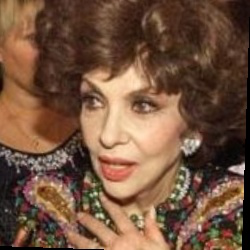

(250, 250, 3) 



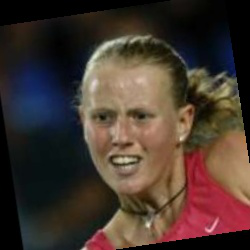

(250, 250, 3) 



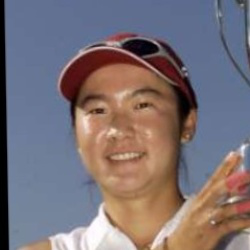

(250, 250, 3) 



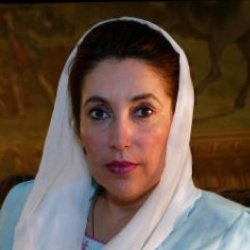

(250, 250, 3) 



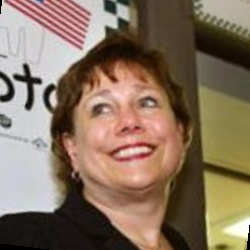

(250, 250, 3) 



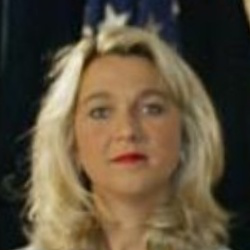

(250, 250, 3) 



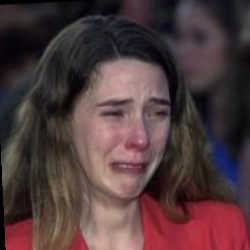

(250, 250, 3) 



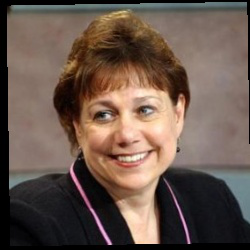

(250, 250, 3) 



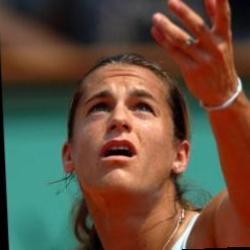

(250, 250, 3) 



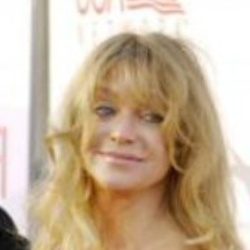

(250, 250, 3) 



In [ ]:
for fich in ficheros_female[:10]:
    imagen = load_img(fich)
    display(imagen)
    print(np.array(imagen).shape, "\n")

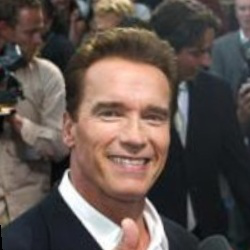

(250, 250, 3) 



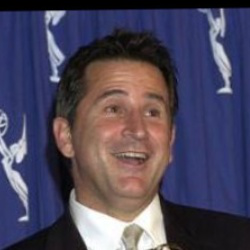

(250, 250, 3) 



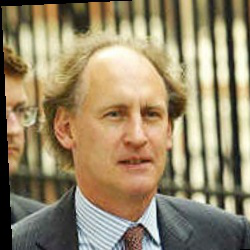

(250, 250, 3) 



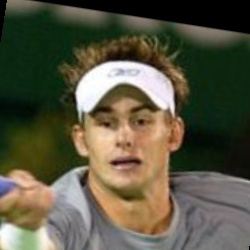

(250, 250, 3) 



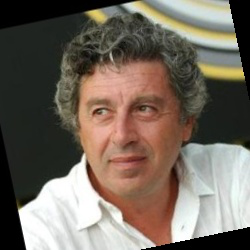

(250, 250, 3) 



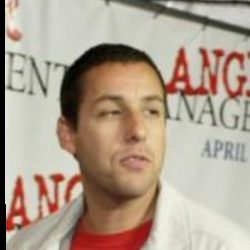

(250, 250, 3) 



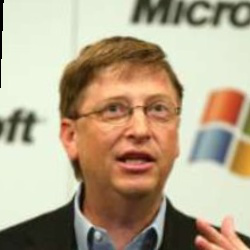

(250, 250, 3) 



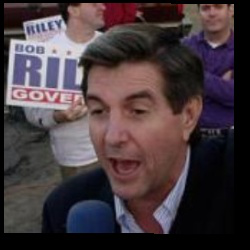

(250, 250, 3) 



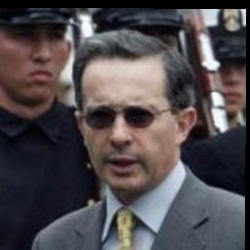

(250, 250, 3) 



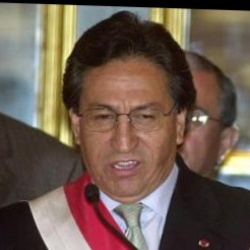

(250, 250, 3) 



In [ ]:
ficheros_male = glob("./gender/male/*jpg")
for fich in ficheros_male[:10]:
    imagen = load_img(fich)
    display(imagen)
    print(np.array(imagen).shape, "\n")

In [ ]:
ficheros_male[:5]

['./gender/male/Arnold_Schwarzenegger_0012.jpg',
 './gender/male/Anthony_LaPaglia_0001.jpg',
 './gender/male/Andrew_Gilligan_0001.jpg',
 './gender/male/Andy_Roddick_0015.jpg',
 './gender/male/Antonio_Catania_0001.jpg']

In [ ]:
ficheros = ficheros_female + ficheros_male
clases   = ["female"]*len(ficheros_female) + ["male"]*len(ficheros_male)

In [ ]:
len(ficheros), len(clases)

(2153, 2153)

In [ ]:
extrae_nombre = lambda x: "_".join(x.split("/")[-1].split("_")[:-1])

extrae_nombre(ficheros[0])

'Gina_Lollobrigida'

In [ ]:
df  = pd.DataFrame({"filepath":ficheros, "class":clases})
df

,filepath,class
0,./gender/female/Gina_Lollobrigida_0001.jpg,female
1,./gender/female/Daja_Bedanova_0001.jpg,female
2,./gender/female/Candie_Kung_0004.jpg,female
3,./gender/female/Benazir_Bhutto_0001.jpg,female
4,./gender/female/Ann_Veneman_0004.jpg,female
...,...,...
2148,./gender/male/Bob_Hayes_0001.jpg,male
2149,./gender/male/Abdoulaye_Wade_0004.jpg,male
2150,./gender/male/Brent_Coles_0001.jpg,male
2151,./gender/male/Alejandro_Toledo_0034.jpg,male


In [ ]:
names_female = np.unique([extrae_nombre(x) for x in ficheros_female]).tolist()
names_female[:5]

['Adelina_Avila',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Afton_Smith']

In [ ]:
names_male = np.unique([extrae_nombre(x) for x in ficheros_male]).tolist()
names_male[:5]

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena']

In [ ]:
from sklearn.model_selection import train_test_split

names_tr_aux_male, names_te_male = train_test_split(names_male, test_size=0.3,
                                                    random_state=1)
names_tr_aux_female, names_te_female = train_test_split(names_female, test_size=0.3,
                                                        random_state=2)
names_tr_male, names_val_male = train_test_split(names_tr_aux_male, test_size=0.3,
                                                 random_state=3)
names_tr_female, names_val_female = train_test_split(names_tr_aux_female, test_size=0.3,
                                                     random_state=4)
print(len(names_tr_male), len(names_tr_female))
print(len(names_val_male), len(names_val_female))
len(names_te_male), len(names_te_female)

249 270
107 117


(153, 167)

In [ ]:
names_tr = names_tr_female + names_tr_male
inds = [i for i,x in enumerate(df["filepath"].values) if extrae_nombre(x) in names_tr]
df_tr = df.iloc[inds]
df_tr[:5]

,filepath,class
1,./gender/female/Daja_Bedanova_0001.jpg,female
2,./gender/female/Candie_Kung_0004.jpg,female
6,./gender/female/Erin_Runnion_0004.jpg,female
8,./gender/female/Amelie_Mauresmo_0014.jpg,female
10,./gender/female/Bridgette_Wilson-Sampras_0001.jpg,female


In [ ]:
names_val = names_val_female + names_val_male
inds = [i for i,x in enumerate(df["filepath"].values) if extrae_nombre(x) in names_val]
df_val = df.iloc[inds]
df_val[:5]

,filepath,class
3,./gender/female/Benazir_Bhutto_0001.jpg,female
4,./gender/female/Ann_Veneman_0004.jpg,female
7,./gender/female/Ann_Veneman_0003.jpg,female
11,./gender/female/Ann_Veneman_0005.jpg,female
13,./gender/female/Janice_Goldfinger_0001.jpg,female


In [ ]:
names_te = names_te_female + names_te_male
inds = [i for i,x in enumerate(df["filepath"].values) if extrae_nombre(x) in names_te]
df_te = df.iloc[inds]
df_te[:5]

,filepath,class
0,./gender/female/Gina_Lollobrigida_0001.jpg,female
5,./gender/female/Alice_Fisher_0002.jpg,female
9,./gender/female/Goldie_Hawn_0001.jpg,female
16,./gender/female/Gillian_Anderson_0001.jpg,female
18,./gender/female/Hana_Makhmalbaf_0001.jpg,female


In [ ]:
len(df_tr), len(df_val), len(df_te)

(991, 476, 686)

In [ ]:
batch_size = 16

A continuación vamos a definir un ImageDataGenerator que es lo que nos servirá para realizar data augmentation.

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [ ]:
#preprocess_input = lambda x:x/255.

def preprocess_input(x):
    nrows = x.shape[0]
    ncols = x.shape[1]
    aux1 = int(0.15*nrows)
    aux2 = int(0.15*ncols)
    x[(nrows-2*aux1):] = 0
    x[:, :aux2] = 0
    x[:, (ncols-aux2):] = 0
    return x / 255.

In [ ]:
# data augmentation:

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
imagen_num = np.expand_dims(np.array(imagen), axis=0)

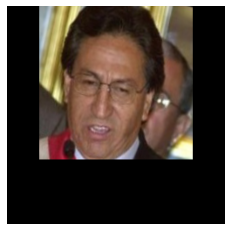

In [ ]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

## **Red convolucional**

In [ ]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [ ]:
normed_dims

(150, 150)

###**Loss del modelo por defecto en clasificación**

El loss típico en redes neuronales y regresión logística (función de coste que minimiza el algoritmo de optimización) es el llamado **cross-entropy** (entropía cruzada) o **log-loss**:

**log-loss = promedio( ln ( 1 / Pmodelo(clase real) ))**

donde ln es el logaritmo neperiano y Pmodelo(clase real) es la probabilidad, según el modelo, de la clase real para un ejemplo concreto.

El log-loss nunca puede ser negativo ya que (1 / Pmodelo) es mayor o igual que 1 y por tanto el logaritmo nunca es menor que cero.

Por otra parte la única manera de que el log-loss sea cero es que Pmodelo(clase real) sea siempre 1, lo que equivale a decir que el modelo siempre acierta con la clase "sin dudarlo" (la probabilidad asignada es siempre 1).

Algunos ejemplos con diferentes probabilidades:

- Si Pmodelo(clase real) = 1 entonces ln( 1 / Pmodelo(clase real) ) = ln(1 / 1) = 0

- Si Pmodelo(clase real) = 0.8 (el modelo "acierta" pero no está completamente seguro) entonces ln( 1 / Pmodelo (clase real) ) = ln(1 / 0.8) > 0

- Si Pmodelo(clase real) = 0 (el modelo se equivoca completamente), ln( 1 / Pmodelo (clase real) ) = ln(1 / 0) = infinito

Una variante del log-loss es introducir pesos en las clases. En keras esto se introduce en el parámetro class_weight en el método **fit** para entrenar el modelo. La variante es entonces:

**log-loss = promedio( peso clase real · ln ( 1 / Pmodelo(clase real) ))**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',
                 input_shape=normed_dims+(3,)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
# aqui empieza la red neuronal 'standard'
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation("softmax")) # Separamos la función de activación del dense para el
# cálculo posterior de los heatmaps
model.compile(loss='sparse_categorical_crossentropy',
#              optimizer=optimizers.RMSprop(lr=1e-4),
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

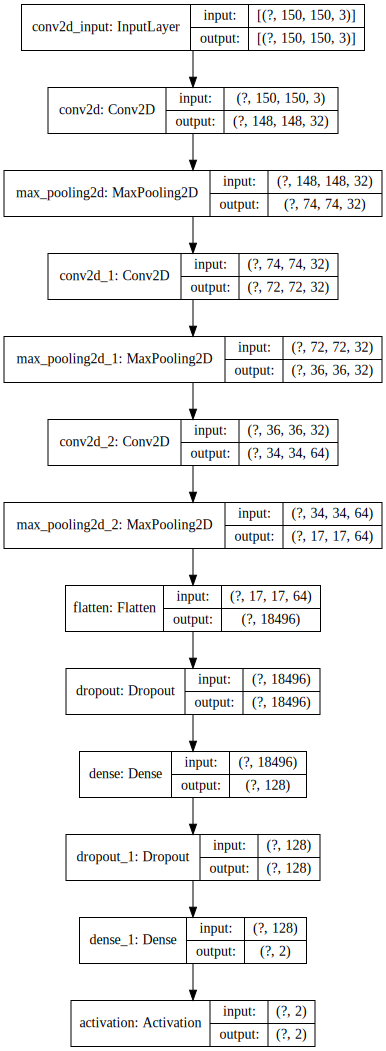

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [ ]:
normed_dims

(150, 150)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_tr,
    x_col = "filepath",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col = "filepath",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_te,
    x_col = "filepath",
    y_col = "class",
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

Found 991 validated image filenames belonging to 2 classes.
Found 476 validated image filenames belonging to 2 classes.
Found 686 validated image filenames belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [ ]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(991, 476, 686)

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

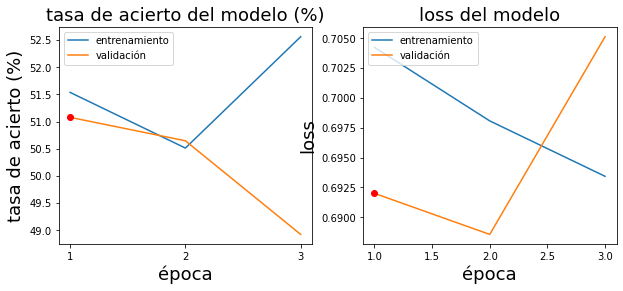

61/61 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5615

KeyboardInterrupt: ignored

In [ ]:
epochs = 50

modelpath="best_model.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
!ls -la

In [ ]:
model = load_model(modelpath)

## **Resultados obtenidos**

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

In [ ]:
print(len(test_generator.classes))
test_generator.classes[:5]

In [ ]:
y_real = np.array(test_generator.classes)
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))

In [ ]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

## **Visualización de ejemplos de test**

In [ ]:
test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

test_generator2 = test_datagen.flow_from_dataframe(
    dataframe=df_te,
    x_col = "filepath",
    y_col = "class",
    target_size=normed_dims,
    batch_size=test_generator.n, # todas las imágenes del directorio test
    shuffle=False,
    class_mode='sparse') # binary: 0/1. Sparse: entero a partir de 0. Categorical: one hot

In [ ]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [ ]:
X_te.shape

In [ ]:
X_te.max()

In [ ]:
class_indices = test_generator2.class_indices
class_indices

In [ ]:
ind_te1 = 150

image = X_te[ind_te1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["female"]]
print("Probabilidad female: {:2.1f}%".format(100*p))
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["male"]]
print("Probabilidad male  : {:2.1f}%".format(100*p))

## **Visualización del funcionamiento de la red**

In [ ]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

In [ ]:
# kernels de la primera capa convolucional
ncapa = 0

nfilters = weights[ncapa].shape[3]
ncols = 7 # número de columnas en la figura

ma = abs(weights[ncapa]).max()
nrows = int(np.ceil(nfilters/ncols)) # número de filas en la figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15*nrows/ncols))
axes_r = axes.ravel()
for i in range(nfilters):
    kernel = weights[ncapa][:,:,2,i]
    ax = axes_r[i]
    ax.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('pesos kernel %d' % i, fontsize=10)
for i in range(nfilters,nrows*ncols):
    fig.delaxes(axes_r[i])

### **Visualización de las salidas de una sola capa**

In [ ]:
# salida de una sola capa
ncapa = 0
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)
intermediate_layer_model.summary()
print("\n\n")
if COLAB:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
imagen = X_te[100]
imagen.shape

In [ ]:
ejemplo = 10

imagen = X_te[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

### **Visualización de las salidas de varias capas**

In [ ]:
# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_te[ejemplo:(ejemplo+1)])

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### **¿A qué partes de la imagen de entrada es más sensible la salida de la red?**

### **GradCam:**

(de https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

1- Calcular para una imagen la salida del modelo y la salida de la última capa convolucional

2- Encuentrar la neurona de salida más activa (que es la que determina la clase predicha)

3- Calcular el gradiente de dicha neurona de salida con respecto a la última capa convolucional

3- Promediar y pesar esto con la salida de la última capa convolucional

4- Normalizar entre 0 y 1 para visualizar

5- Convertir a RGB y superponerla a la imagen original

**Funciones que calculan la sensibilidad de la salida a la entrada:**

In [ ]:
import tensorflow as tf

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices["female"]]
    print("Probabilidad clase female: {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["male"]]
    print("Probabilidad clase male  : {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

**Visualización de mapas de sensibilidades (heatmaps) en varios ejemplos:**

In [ ]:
X_te[i].max()

In [ ]:
ind = 200 # visualizamos 10 ejemplos de test a partir de este (en test hay 2002 ejemplos)

for i in range(ind, ind+10):
    show_heatmap(model, X_te[i])

In [ ]:
ind = 400 # visualizamos 10 ejemplos de test a partir de este (en test hay 2002 ejemplos)

for i in range(ind, ind+10):
    show_heatmap(model, X_te[i])

### **Ahora analizamos las mayores equivocaciones de la CNN en test**

**Clase female que la red está segura que son male:**

In [ ]:
# obtengo los índices a todos los ejemplos de test que son de clase female:
inds = np.where(y_te==class_indices["female"])[0]
# ordeno dichos índices por probabilidad creciente de female, por lo que los primeros
# son los que más probabilidad tienen de male:
inds = sorted(inds, key=lambda i:y_pred_proba[i][class_indices["female"]])

# Saco información sobre heatmaps:
for i in inds[:10]:
    show_heatmap(model, X_te[i])

**Clase male que la red está segura que son female:**

In [ ]:
# obtengo los índices a todos los ejemplos de test que son de clase male:
inds = np.where(y_te==class_indices["male"])[0]
# ordeno dichos índices por probabilidad creciente de male, por lo que los primeros
# son los que más probabilidad tienen de female:
inds = sorted(inds, key=lambda i:y_pred_proba[i][class_indices["male"]])

# Saco información sobre heatmaps:
for i in inds[:10]:
    show_heatmap(model, X_te[i])